In [ ]:
### Astrometry corrected & Envelope extinction corrected ###

In [10]:
import numpy as np
import os, glob
import math
import matplotlib
from matplotlib import rc,ticker
import matplotlib.pyplot as plt
from matplotlib import font_manager

from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from scipy.signal import savgol_filter
from statistics import median

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

from astropy.io import fits
from astropy.table import Table

from scipy import integrate

In [11]:
# Register the font
font_path = '/usr/share/fonts/liberation-sans/LiberationSans-Regular.ttf'
font_manager.fontManager.addfont(font_path)

# Get the actual family name (it must match the internal font name)
liberation = font_manager.FontProperties(fname=font_path)
font_name = liberation.get_name()  # usually "Liberation Sans"
print(font_name)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# Set it globally
plt.rcParams['font.family'] = font_name
plt.rcParams['font.sans-serif'] = [font_name]

plt.rcParams.update({
    'axes.linewidth': 0.5,      # axes spines
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
    'xtick.minor.width': 0.3,
    'ytick.minor.width': 0.3,
})

Liberation Sans


In [2]:
fig_path = r"D:\Python\JWST\EPISODE\New_result\Astrometry_v4"

In [3]:
### Road 1d MIR spectrum reproduced by Chul-Hwan

file_name_Q = 'EC53_Q_MIRI_aperture.txt'
file_name_B = 'EC53_B_MIRI_aperture.txt'
Target='EC53 Q and B phases'

def read_file(file_name):
    foo = open(file_name,"r")
    lines = foo.readlines()
    wave_file = []; flux_file = []
    for col1 in lines:
        wave_file.append(col1.split(',')[0])
    for col2 in lines:
        flux_file.append(col2.split(',')[1])
    foo.close
    wave_MIR = np.array(wave_file, np.float64)
    flux_MIR = np.array(flux_file, np.float64)

    # wave_NIR_Q, flux_NIR_Q, fluxE_NIR_Q = np.loadtxt(file_name_NIRSpec_Q,unpack=True,skiprows=1)
    flux_MIR = flux_MIR*1000.
    fluxE_MIR = np.diff(flux_MIR, append=flux_MIR[-1])
        
    return wave_MIR, flux_MIR, fluxE_MIR

wave_MIR_Q, flux_MIR_Q, fluxE_MIR_Q = read_file(file_name_Q)
wave_MIR_B, flux_MIR_B, fluxE_MIR_B = read_file(file_name_B)

# scale_factor = flux_MIR_B/flux_MIR_Q
# m_scale = median(scale_factor)

# flux_MIR_Q = flux_MIR_Q*m_scale

In [4]:
def polynomial_curve_MIR(wave, flux, flux_err, degree_num, ep):
    ind_1 = np.where((wave <= 5.1) & (wave >= 4.9))
    ind_2 = np.where((wave <= 5.6) & (wave >= 5.4))
    ind_3 = np.where((wave <= 8.) & (wave >= 7.8))
    ind_4 = np.where((wave <= 14.5) & (wave >= 13.)) 
    ind_5 = np.where((wave <= 21.5) & (wave >= 20.))    
    ind_6 = np.where((wave <= 23.5) & (wave >= 22.)) 
    ind_7 = np.where((wave <= 25.8) & (wave >= 24.))
    ind_8 = np.where((wave <= 27.5) & (wave >= 26.1))


    wave_1 = wave[ind_1]; wave_2 = wave[ind_2]; wave_3 = wave[ind_3] 
    wave_4 = wave[ind_4]; wave_5 = wave[ind_5]; wave_6 = wave[ind_6]
    wave_7 = wave[ind_7]; wave_8 = wave[ind_8]
    flux_1 = flux[ind_1]; flux_2 = flux[ind_2]; flux_3 = flux[ind_3] 
    flux_4 = flux[ind_4]; flux_5 = flux[ind_5]; flux_6 = flux[ind_6]
    flux_7 = flux[ind_7]; flux_8 = flux[ind_8]

    if ep == 'Q':
        coeff_1=0.95; coeff_2=1.15
        coeff_3=1.03; coeff_4=1.89
        coeff_5=2.35; coeff_6=1.35; coeff_7=1.63; coeff_8=1.26
    if ep == 'B':
        coeff_1=1.0; coeff_2=1.10
        coeff_3=1.0; coeff_4=1.88
        coeff_5=2.24; coeff_6=1.15; coeff_7=1.68; coeff_8=1.22
        
        
    xp = np.concatenate((wave_1, wave_2, wave_3, wave_4, wave_5, wave_6, wave_7, wave_8), axis=0)
    yp = np.concatenate((flux_1*coeff_1, flux_2*coeff_2, flux_3*coeff_3, flux_4*coeff_4, flux_5*coeff_5, 
                         flux_6*coeff_6, flux_7*coeff_7, flux_8*coeff_8), axis=0)
    

    
    degree = degree_num
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    x = xp[:, np.newaxis]
    y = yp[:, np.newaxis]
    #print(x)
    model.fit(x,y)

    X_plot = wave[:, np.newaxis]
    y_plot = model.predict(X_plot)
    #plt.plot(X_plot, y_plot, 'g--', label="Polynomial deg. %d" % degree)
    
    return xp, yp, X_plot, y_plot 

deg_num = 4
xp_MIR_Q, yp_MIR_Q, x_train_MIR_Q, y_train_MIR_Q = polynomial_curve_MIR(wave_MIR_Q, flux_MIR_Q, fluxE_MIR_Q, 
                                                                                     deg_num, 'Q')

fluxC_MIR_Q = y_train_MIR_Q[:,0]
flux_c_MIR_Q = flux_MIR_Q/y_train_MIR_Q[:,0]
flux_ce_MIR_Q = fluxE_MIR_Q/(y_train_MIR_Q[:,0])

etau_MIR_Q = flux_c_MIR_Q
tau_MIR_Q = -1.0*np.log(flux_c_MIR_Q)
tau_err_MIR_Q = -1.0*np.log(flux_ce_MIR_Q)

flux1_MIR_B = flux_MIR_B/etau_MIR_Q
# flux1Err_MIR_B = flux_MIR_B/flux_ce_MIR_Q
flux1Err_MIR_B = np.sqrt( (fluxE_MIR_B/etau_MIR_Q)**2 +
                          (flux_MIR_B*flux_ce_MIR_Q/etau_MIR_Q**2)**2 )


/tmp/ipykernel_4041798/3732697348.py:58: RuntimeWarning: divide by zero encountered in log
  tau_err_MIR_Q = -1.0*np.log(flux_ce_MIR_Q)
/tmp/ipykernel_4041798/3732697348.py:58: RuntimeWarning: invalid value encountered in log
  tau_err_MIR_Q = -1.0*np.log(flux_ce_MIR_Q)


In [6]:
def poly_fit_spec(wave, flux, wave1_min, wave1_max, wave2_min, wave2_max, 
                 wave3_min, wave3_max, wave4_min, wave4_max, degree_num):
    ind_1 = np.where((wave <= wave1_max) & (wave >= wave1_min))
    ind_2 = np.where((wave <= wave2_max) & (wave >= wave2_min))
    ind_3 = np.where((wave <= wave3_max) & (wave >= wave3_min))
    ind_4 = np.where((wave <= wave4_max) & (wave >= wave4_min))

    wave_1 = wave[ind_1]; wave_2 = wave[ind_2]; wave_3 = wave[ind_3]; wave_4 = wave[ind_4] 

    flux_1 = flux[ind_1]; flux_2 = flux[ind_2]; flux_3 = flux[ind_3]; flux_4 = flux[ind_4] 
    
    xp = np.concatenate((wave_1, wave_2, wave_3, wave_4), axis=0)
    yp = np.concatenate((flux_1, flux_2, flux_3*0.99, flux_4), axis=0)

    #plt.plot(xp,yp, 'rD', markersize=2.0, label='Fitting points')
    

    
    degree = degree_num
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    x = xp[:, np.newaxis]
    y = yp[:, np.newaxis]
    #print(x)
    model.fit(x,y)

    X_plot = wave[:, np.newaxis]
    y_plot = model.predict(X_plot)
    #plt.plot(X_plot, y_plot, 'g--', label="Polynomial deg. %d" % degree)
    
    return xp, yp, X_plot, y_plot 

xp_MIR_B, yp_MIR_B, x_train_MIR_B, y_train_MIR_B = poly_fit_spec(wave_MIR_Q, flux1_MIR_B,
                                                                5.0,7.0, 12.90,13.50, 23.00,24.00, 27.0,30.0, 4)

Baseline_MIR_B = y_train_MIR_B[:,0]
Emission_spec_MIR = (flux1_MIR_B-Baseline_MIR_B)*1.

Spec_Emission_baseline = open('Spec_Emission_Baseline_B_revision_v4.txt', 'w')
for i in range(len(wave_MIR_Q)):
    Spec_Emission_baseline.write("%15.10f %15.10f %15.10f \n" % 
                      (wave_MIR_Q[i], flux1_MIR_B[i], Baseline_MIR_B[i]))
Spec_Emission_baseline.close()

########### Smoothing the lab data ##########################
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
#############################################################

tau_MIR_Emiss0 = -1.0*np.log(1-(Emission_spec_MIR/Baseline_MIR_B))       
# tau_MIR_Emiss = -1.0*np.log(1-(Emission_Spec_sel/Baseline_MIR_B))
tau_MIR_Emiss1 = smooth(tau_MIR_Emiss0,30)
# tau_MIR_Emiss00 = smooth(tau_MIR_Emiss0,30)
# print(tau_MIR_Emiss1)

ind_s = np.where((wave_MIR_Q <= 17.82));ind_l = np.where((wave_MIR_Q >= 18.08))
wave_s = wave_MIR_Q[ind_s]; wave_l = wave_MIR_Q[ind_l]
cut_tau_s = tau_MIR_Emiss1[ind_s]; cut_tau_l = tau_MIR_Emiss1[ind_l]
wave_cut = np.concatenate([wave_s,wave_l], axis=0)
tau_cut = np.concatenate([cut_tau_s,cut_tau_l], axis=0)
intp_1d = interp1d(wave_cut, tau_cut, kind='linear')
tau_MIR_Emiss2 = intp_1d(wave_MIR_Q)
tauErr_MIR_Emiss2 = np.diff(tau_MIR_Emiss2, append=tau_MIR_Emiss2[-1])

Spec_Emission_tau = open('Spec_Emission_tau_B_revision_v4.txt', 'w')
for i in range(len(wave_MIR_Q)):
    Spec_Emission_tau.write("%15.10f %15.10f \n" % 
                      (wave_MIR_Q[i], tau_MIR_Emiss2[i]))
Spec_Emission_tau.close()

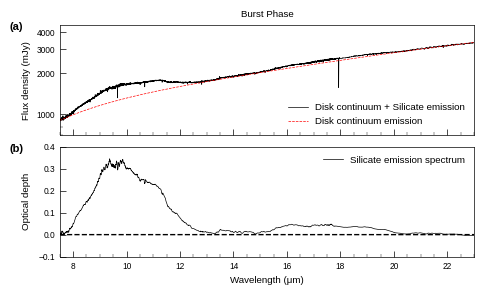

In [32]:
fig, axs = plt.subplots(2, 1, figsize=(12/2.54, 12/2.54*0.6), constrained_layout=True, sharex=True)


axs[0].plot(wave_MIR_B, flux1_MIR_B, color='black',linestyle='-', lw=0.5, label ='Disk continuum + Silicate emission')
# axs[0].plot(wave_MIR_B, flux1Err_MIR_B, color='red',linestyle='-', lw=2, alpha=0.3)
# axs[0].fill_between(wave_MIR_B, flux1_MIR_B-abs(flux1Err_MIR_B), flux1_MIR_B+abs(flux1Err_MIR_B), color='blue', 
#                       interpolate=True, alpha=0.3)
axs[0].plot(wave_MIR_Q, Baseline_MIR_B, color='red', linestyle='--', lw=0.5, label="Disk continuum emission")


axs[0].set_xlim(7.5, 23.)
axs[0].set_ylim(700., 4500.)
axs[0].legend(loc='lower right', fontsize=7, frameon=False)
axs[0].set_yscale("log")
axs[0].set_ylabel(r'Flux density (mJy)', fontsize=7)
axs[0].set_yticks([1000,2000,3000,4000])
axs[0].get_yaxis().set_major_formatter(ticker.ScalarFormatter())

zeroline = np.zeros(len(wave_MIR_Q))

axs[1].plot(wave_MIR_Q, tau_MIR_Emiss2, color='black',linestyle='-', lw=0.5, label ='Silicate emission spectrum')

axs[1].plot(wave_MIR_Q, zeroline, 'k--', lw=1.)

axs[1].set_ylim(-0.1, 0.4)


for ax in axs:
    ax.tick_params(axis='both', which='major', length=4, labelsize=6)
    ax.tick_params(axis='both', which='minor', length=2)

axs[1].set_xlabel('Wavelength (μm)', fontsize=7)
axs[1].set_ylabel(r'Optical depth', fontsize=7)
axs[1].legend(loc='upper right', fontsize=7, frameon=False)

fig.align_ylabels(axs)

axs[0].text(-0.12, 1.03, '(a)', transform=axs[0].transAxes, fontsize=8, fontweight='bold', va='top', ha='left')
axs[1].text(-0.12, 1.03, '(b)', transform=axs[1].transAxes, fontsize=8, fontweight='bold', va='top', ha='left')


axs[0].set_title('Burst Phase', fontsize=7)

axs[1].xaxis.set_minor_locator(ticker.MultipleLocator(0.5))


fig.set_size_inches(12/2.54, 12/2.54*0.6)

fig.savefig('./Final_FigExt4.pdf', bbox_inches=None)